In [1]:
import timeit
import pandas as pd
import numpy as np
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi']=300
# plt.style.use('bmh')

# Initialize the RandomUnderSampler with a sampling strategy of 'majority'
rus = RandomUnderSampler(sampling_strategy='majority')
# Initialize MinMax Scale
scaler = MinMaxScaler()

# Classifiers
classifiers = {"Naive Bayes": GaussianNB(), 
               "Adaptive Boosting": AdaBoostClassifier(), 
               "Decision Tree": DecisionTreeClassifier(), 
               "Random Forest": RandomForestClassifier(random_state=42, 
                                            class_weight='balanced',
                                            bootstrap=True,
                                            oob_score=True),
               "Logistic Regression": LogisticRegression(random_state=42)}

f = {'in_degree':'mean', 'out_degree':'mean', 'betweenness':'mean', 
     'closeness':'mean', 'hub':'mean', 'authority':'mean', 'clustering':'mean', 'deg_ratio':'mean',
     'word_count':'sum', 'num_sentences':'sum', 'num_positive':'sum', 'num_negative':'sum', 
     'num_definite':'sum', 'num_indefinite':'sum', 'num_qmarks':'sum', 'num_quotes':'sum', 
     'p1_pronouns':'sum', 'pp1_pronouns':'sum', 'p2_pronouns':'sum', 'num_links':'sum', 
     'hedges':'sum', 'examples':'sum', 
     'word_entropy':'mean', 'token_type_entropy':'mean', 'num_common_words':'sum', 
     'a_reply_fraction':'mean', 'op_fraction':'mean', 'jaccard_similarity':'mean', 'cosine_similarity':'mean', 
     'comments_all':'sum', 'comments_to_op':'sum', 'comments_from_op':'sum', 'comments_to_others':'sum', 
     'comments_back_forth':'sum', 'entry_time':'mean'
    }

nx_features = ['deg_ratio']

lang_features = ['word_count',
 'examples',
 'hedges',
 'num_sentences',
 'num_positive',
 'num_negative',
 'num_definite',
 'num_indefinite',
 'p1_pronouns',
 'pp1_pronouns',
 'p2_pronouns',
 'num_qmarks',
 'num_quotes',
 'num_links',
 'word_entropy',
 'token_type_entropy',
 'num_common_words',
 'a_reply_fraction',
 'op_fraction',
 'jaccard_similarity']

all_features = nx_features + lang_features 

def predict_class(proba, cutoff):
    if proba > cutoff:
        y = 1
    else:
        y = 0
    return y


def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)
    
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]

        clf_class.fit(X_train,y_train)

        y_prob[test_index] = clf_class.predict_proba(X_test)
    return y_prob

def evaluation_summary(X,y):
    eval_df = pd.DataFrame()
    acc_, prec_, rec_, f1_, auc_, names = [], [], [], [], [], []
    for name, clf in classifiers.items():
        names.append(name)
        start = timeit.default_timer()

        probs = run_prob_cv(X,y,clf)
        
        fpr, tpr, threshold = metrics.roc_curve(y, probs[:,1])
        
        y_pred = [predict_class(prob, 0.5) for prob in probs[:,1]]
        
        acc_.append(accuracy(y, y_pred))
        prec_.append(precision(y, y_pred))
        rec_.append(recall(y, y_pred))
        f1_.append(f1(y, y_pred))
        
        auc_.append(metrics.auc(fpr, tpr))
        
        stop = timeit.default_timer()
#         print ("Completed {0} in {1} seconds".format(name, (stop-start)))
        
    eval_df['Model'] = names
    eval_df['Accuracy'] = acc_
    eval_df['Precision'] = prec_
    eval_df['Recall'] = rec_
    eval_df['F1'] = f1_
    eval_df['AUC'] = auc_
    
    return eval_df

def accuracy(y_true,y_pred): return metrics.accuracy_score(y_true, y_pred)
def precision(y_true, y_pred): return metrics.precision_score(y_true, y_pred)
def recall(y_true, y_pred): return metrics.recall_score(y_true, y_pred)
def f1(y_true, y_pred): return metrics.f1_score(y_true, y_pred)


Bad key text.latex.preview in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when

In [2]:
# Delta outcomes
delta_df = pd.read_csv('../../Data/intermediate/utterances_delta.csv')
delta_df = delta_df[['speaker', 'delta']]
delta_df = delta_df.groupby('speaker').agg(sum).reset_index()
# Commenter network measures
network_features = pd.read_csv('../../Data/output/challenger_local_network_features.csv')
network_features['out_degree'] = network_features['out_degree']+0.00001
network_features['in_degree'] = network_features['in_degree']+0.00001
network_features['deg_ratio'] = network_features['out_degree']/network_features['in_degree']
# Commenter argument features
argument_features = pd.read_csv('../../Data/output/user_word_category_features.csv')
# Commenter interplay features
interplay_features = pd.read_csv('../../Data/output/user_interplay_features.csv')
# Interaction features
interaction_features = pd.read_csv('../../Data/output/user_interaction_dynamics.csv')
# Readability Features
readability_features = pd.read_csv('../../Data/output/challenger_readability.csv')
readability_features = readability_features[['speaker', 'grade_level', 'readability_score']]
readability_features = readability_features.groupby('speaker').agg('mean').reset_index()

data = network_features.merge(argument_features, on =['conversation_id', 'speaker'], how='left')
data = data.merge(interplay_features, on =['conversation_id', 'speaker'], how='left')
data = data.merge(interaction_features, on =['conversation_id', 'speaker'], how='left')
# filter posts with active op
op_activeness = data[['conversation_id', 'comments_from_op']].groupby('conversation_id').agg('sum').reset_index()
op_activeness['comments_from_op'] = op_activeness['comments_from_op'].astype(int)
op_activeness = op_activeness[op_activeness['comments_from_op']>1]
op_activeness.to_csv('../../Data/output/op_active.csv')
data = data[data.conversation_id.isin(op_activeness.conversation_id.values)]
# drop conversation_id column
data = data[data.columns[1:]]
data = data.groupby('speaker').agg(f).reset_index()
data = data.merge(readability_features, on='speaker', how='left')
data = data.merge(delta_df, on ='speaker', how='left')
data['outcome'] = data.delta > 0
data['outcome'] = data['outcome'].astype(int)
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
data.head()

,speaker,in_degree,out_degree,betweenness,closeness,hub,authority,clustering,deg_ratio,word_count,num_sentences,num_positive,num_negative,num_definite,num_indefinite,num_qmarks,num_quotes,p1_pronouns,pp1_pronouns,p2_pronouns,num_links,hedges,examples,word_entropy,token_type_entropy,num_common_words,a_reply_fraction,op_fraction,jaccard_similarity,cosine_similarity,comments_all,comments_to_op,comments_from_op,comments_to_others,comments_back_forth,entry_time,grade_level,readability_score,delta,outcome
0,--_0,0.000,1.000,0.000,0.325,0.875,0.000,0.000,100001.000,25.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,4.374,2.679,9.000,0.409,0.027,0.026,0.068,1.000,1.000,0.000,0.000,0.000,32876.000,-1.000,-1.000,0,0
1,--thatguy,1.000,1.000,0.000,0.292,0.614,0.018,1.000,1.000,306.000,18.000,3.000,13.000,4.000,0.000,3.000,5.000,19.000,0.000,1.000,0.000,7.000,1.000,6.938,3.529,46.000,0.261,0.194,0.125,0.178,1.000,1.000,0.000,0.000,0.000,27569.000,8.000,66.000,0,0
2,-10-5-19-20-5-18-,0.000,1.000,0.000,0.317,0.008,0.000,0.000,100001.000,17.000,2.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,4.087,3.261,4.000,0.235,0.035,0.031,0.109,1.000,0.000,0.000,1.000,0.000,49451.000,-1.000,-1.000,0,0
3,-1point,0.000,1.000,0.000,0.520,1.000,0.000,0.000,100001.000,45.000,3.000,2.000,1.000,2.000,0.000,1.000,2.000,2.000,0.000,3.000,0.000,1.000,0.000,5.208,3.503,11.000,0.282,0.131,0.098,0.083,1.000,1.000,0.000,0.000,0.000,12160.000,-1.000,-1.000,0,0
4,-5m,1.000,1.000,14.000,0.410,0.979,0.000,0.000,1.000,23.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.350,3.352,11.000,0.524,0.046,0.044,0.085,1.000,1.000,0.000,0.000,0.000,45187.000,-1.000,-1.000,0,0


In [3]:
data.outcome.value_counts()

0    32018
1    1671 
Name: outcome, dtype: int64

In [4]:
## Network Features
X = data[nx_features].to_numpy()
X = scaler.fit_transform(X) # scale variables from 0 to 1 
y = nx_data['outcome'].values # select outcome variable
evaluation_summary(X,y)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Naive Bayes,0.950,0.000,0.000,0.000,0.730
1,Adaptive Boosting,0.950,0.000,0.000,0.000,0.809
2,Decision Tree,0.952,0.569,0.115,0.192,0.746
3,Random Forest,0.801,0.134,0.553,0.216,0.767
4,Logistic Regression,0.950,0.000,0.000,0.000,0.596


In [5]:
# Language Features
X = data[lang_features].to_numpy()
X = scaler.fit_transform(X) # scale variables from 0 to 1 
y = data['outcome'].values # select outcome variable
evaluation_summary(X,y)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Naive Bayes,0.934,0.361,0.422,0.389,0.843
1,Adaptive Boosting,0.956,0.710,0.193,0.304,0.865
2,Decision Tree,0.923,0.254,0.287,0.269,0.621
3,Random Forest,0.956,0.711,0.181,0.288,0.851
4,Logistic Regression,0.955,0.730,0.159,0.261,0.844


In [6]:
# All Features
X = data[all_features].to_numpy()
X = scaler.fit_transform(X) # scale variables from 0 to 1 
y = data['outcome'].values # select outcome variable
evaluation_summary(X,y)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Naive Bayes,0.934,0.362,0.425,0.391,0.864
1,Adaptive Boosting,0.956,0.677,0.197,0.305,0.883
2,Decision Tree,0.922,0.246,0.273,0.259,0.615
3,Random Forest,0.956,0.735,0.186,0.296,0.867
4,Logistic Regression,0.955,0.734,0.160,0.262,0.855


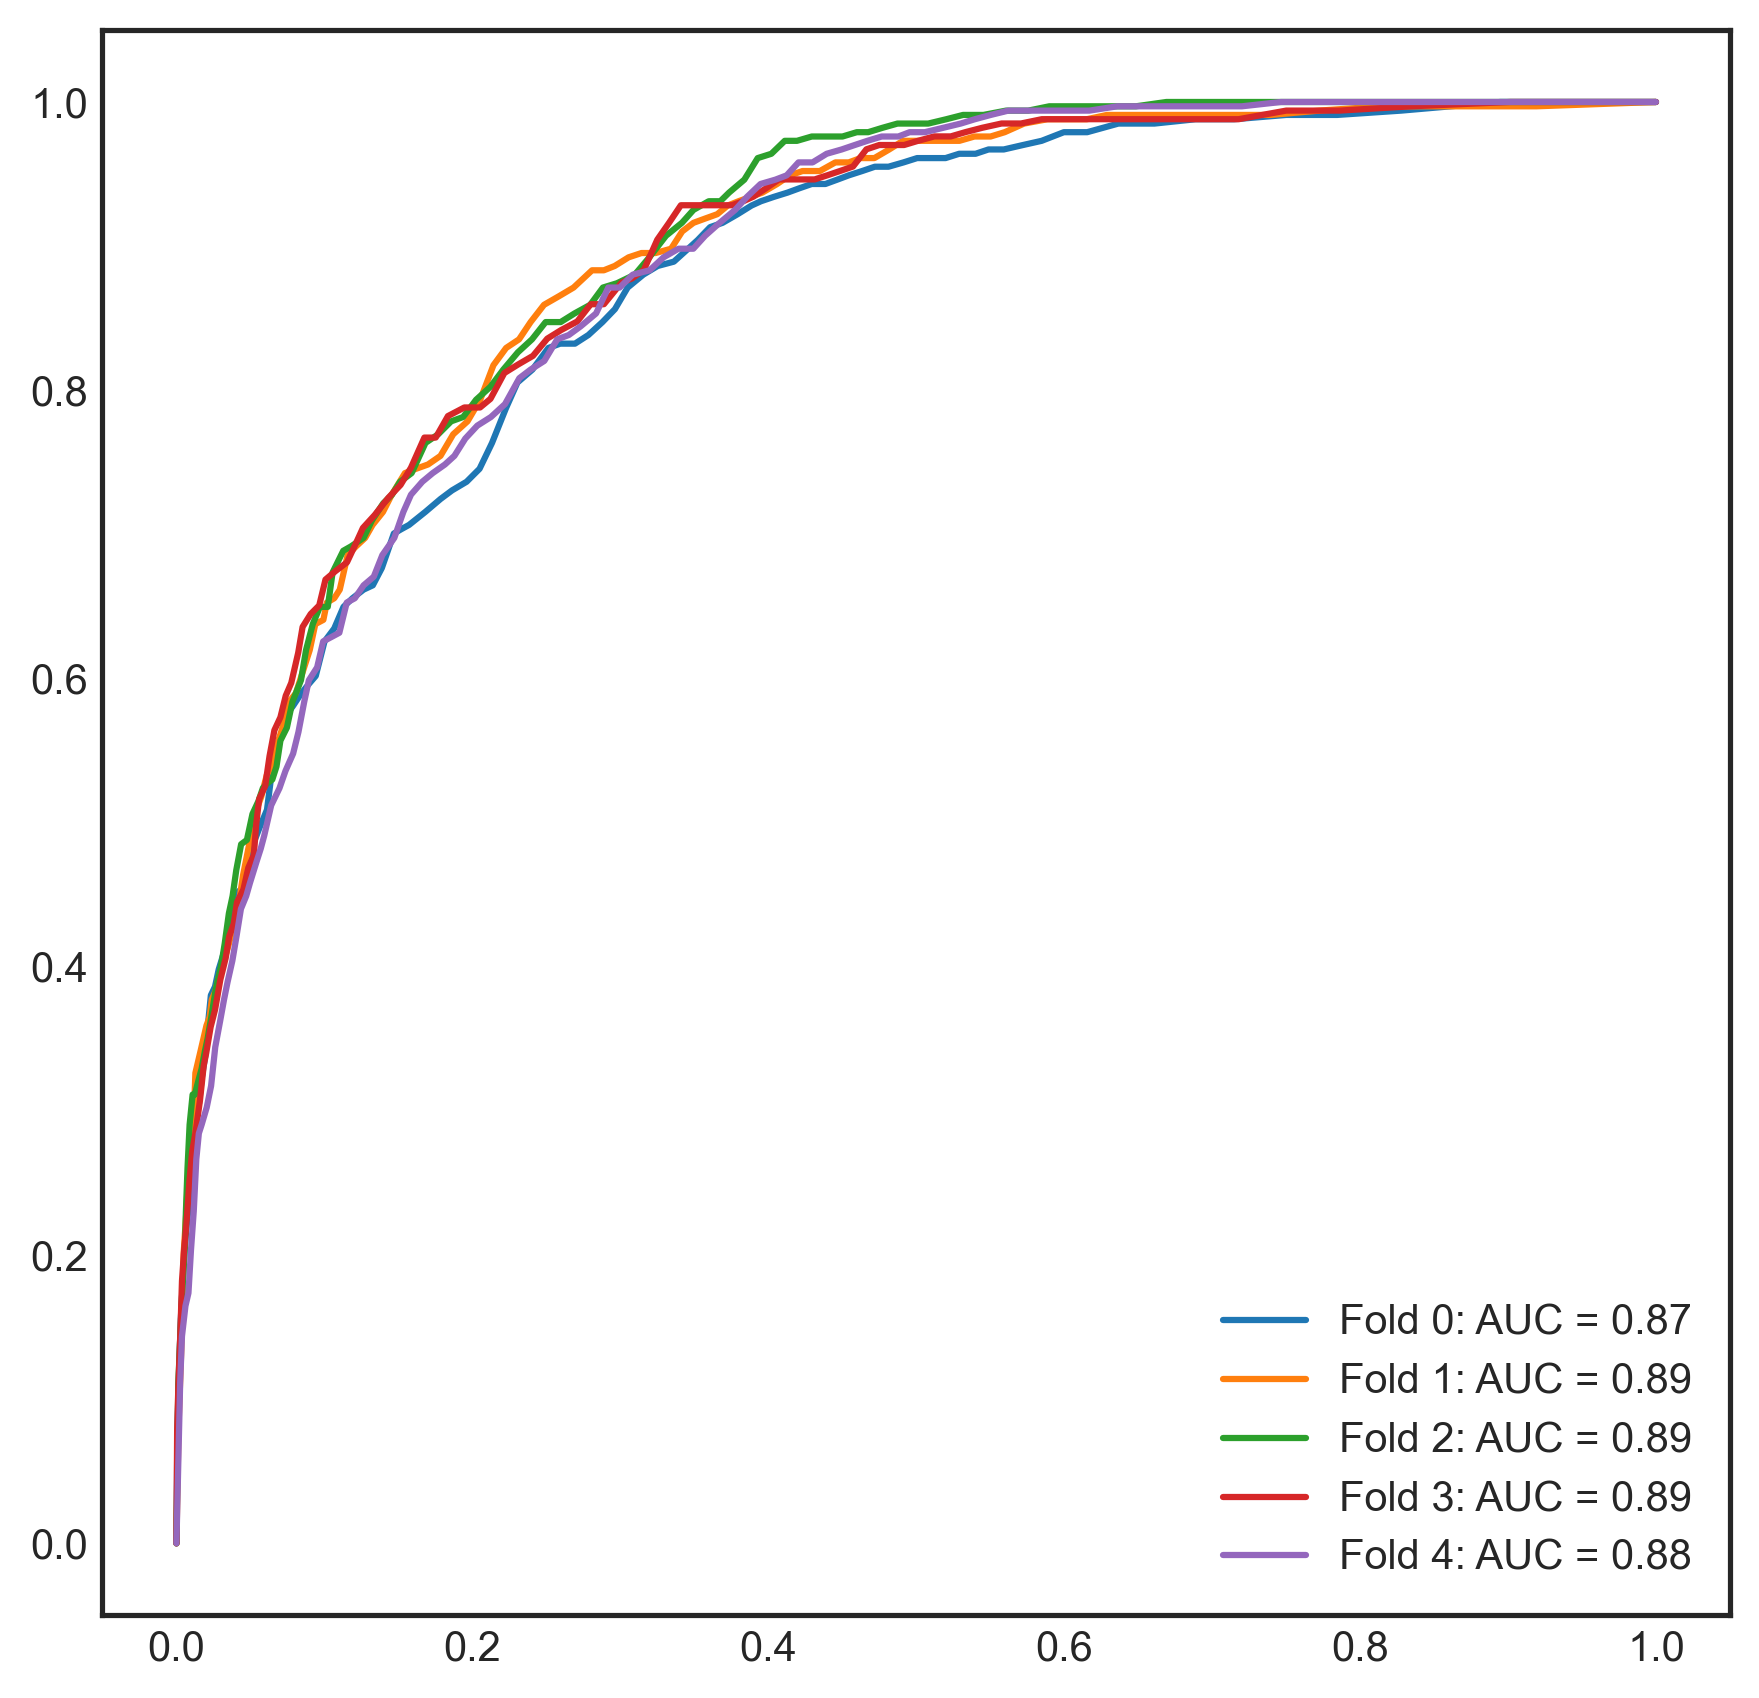

In [11]:
# All Features
X = data[all_features].to_numpy()
X = scaler.fit_transform(X) # scale variables from 0 to 1 
y = data['outcome'].values # select outcome variable

k = 5

# Initialize the KFold object
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the random forest classifier with your desired hyperparameters
rf = RandomForestClassifier(random_state=42, 
                            class_weight='balanced',
                            bootstrap=True,
                            oob_score=True)
figure = plt.figure(figsize=(7, 7),dpi=300)

for fold, (train_index, test_index) in enumerate(kf.split(X,y)):
# for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train, y_train = rus.fit_resample(X_train, y_train)
    # Fit the random forest classifier on the training data for this fold
    rf.fit(X_train, y_train)

    # Make predictions on the testing data for this fold
    
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:,1]

    # Calculate the true positive rate (tpr) and false positive rate (fpr) for this fold
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

    var_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold}: AUC = {round(var_auc,2)}")
    
plt.legend()
plt.show()

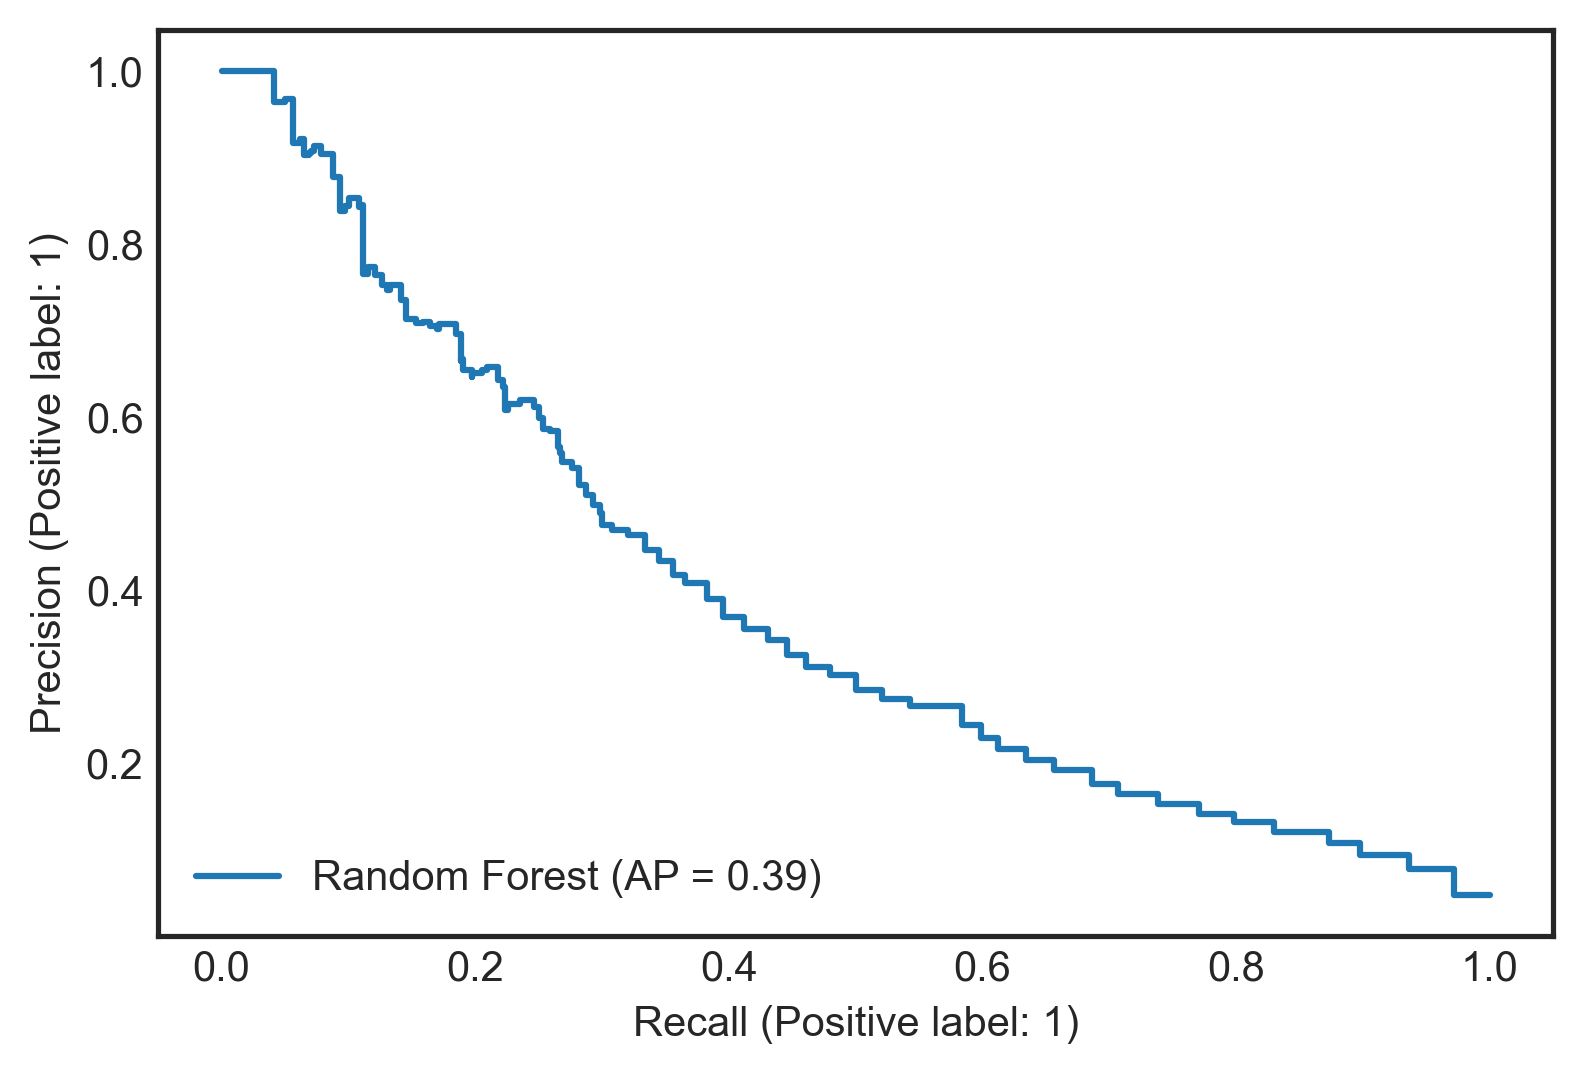

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PrecisionRecallDisplay

classifier = make_pipeline(
    MinMaxScaler(), RandomForestClassifier(random_state=42)
)

X = data[all_features].to_numpy()
y = data['outcome'].values # select outcome variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

classifier.fit(X_train, y_train)


display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="Random Forest"
)
display.figure_.set_dpi(300)